# Machine learning homework 6

## 0 Preparation

### 0.1 Import required librarys

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import display, Image

### 0.2 Read data from files

In [2]:
circle = np.loadtxt('data/circle.txt', delimiter=',')
moon = np.loadtxt('data/moon.txt', delimiter=',')

### 0.3 Take a look at the data

#### Define function to show scatter plot animations

In [3]:
def scatter_animation(x, y, color_steps, save):
    """Animate scatter plot, save and display result."""
    def update_scatter(frame, scat, color_steps):
        """Update scatter color."""
        # Set color of each data point
        scat.set_array(color_steps[:, frame])
        return scat,
    fig, ax = plt.subplots()
    # Must initialize with that number of cluster!!
    scat = ax.scatter(x, y, c=color_steps[:, -1])
    animation = ani.FuncAnimation(fig, update_scatter, frames=color_steps.shape[1],
                                  blit=True, interval=300, repeat_delay=500, fargs=(scat, color_steps))
    plt.close()
    animation.save(save, writer='imagemagick')
    display(Image(filename=save))

#### Define utility function for showing plot and animation

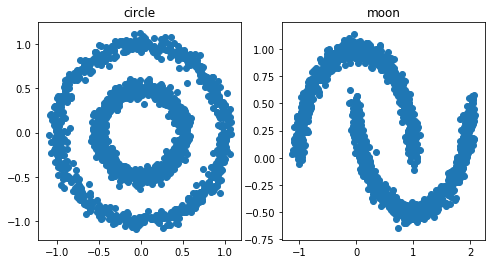

In [4]:
def plot_graph(x1, x2, y1=None, y2=None, title='', animated=False):
    """Plot circle and moon, with or without label, animate or not."""
    y1_final = y1[:, -1] if animated else y1
    y2_final = y2[:, -1] if animated else y2
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(title)
    ax[0].set_title('circle')
    ax[0].scatter(x1[:, 0], x1[:, 1], c=y1_final)
    ax[1].set_title('moon')
    ax[1].scatter(x2[:, 0], x2[:, 1], c=y2_final)
    plt.show()
    if animated:
        scatter_animation(x1[:, 0], x1[:, 1], y1, f'{title}_circle.gif')
        scatter_animation(x2[:, 0], x2[:, 1], y2, f'{title}_moon.gif')
plot_graph(circle, moon)

## 1 Make animation to show clustering procedure

### 1.1 k-means
$J=\sum_{n=1}^{N} \sum_{k=1}^{K} r_{nk} \lVert x_{n}-\mu_{k} \rVert ^{2}$  
The main objective of k-means is to minimize `J`.

#### Define a initialization method
This method randomly assign each sample to one cluster, so cluster overlap each others, resulting in a very similar mean.

In [5]:
def random_assign(x, n_class):
    """Initialization method which random assign class."""
    y = np.random.randint(0, n_class, x.shape[0])
    return y

#### Define E step of k-means
Keep $\mu_{k}$ fixed, minimize `J` with respect to $r_{nk}$  
This method compute the euclidean distance of each pair of `x` and `mean`, then take the index of smallest distance as its cluster.

In [6]:
def assign_cluster(x, means):
    """Assign x to different cluster according to closest mean."""
    # Add a new axis to x
    x_new = x[:, None, :]
    # Compute euclidean distance for each pair of x and mean point
    distance = np.sqrt(np.sum((x_new - means)**2, axis=2))
    # Assign cluster to a point with smallest distance from means
    y = np.argmin(distance, axis=1)
    return y

#### Define M step of k-means
Keep $r_{nk}$ fixed, minimize `J` with respect to $\mu_{k}$  
This method compute new mean point base on new cluster of each `x`.

In [7]:
def compute_means(x, y, k):
    """Compute the mean value for each cluster of x."""
    means = np.array([x[y == c].mean(axis=0) for c in range(k)])
    return means

#### Combine E and M step to perform k-means
Here, we combine the two previous method to form the `kmeans` method, which repeatly assign new cluster and calculate new mean points, until all mean didn't move anymore.

In [8]:
def kmeans(x, k=2, init_method=random_assign, return_step=False):
    """Perform k-means clustering on x."""
    # Randomly assign cluster to each x as initialization
    y = init_method(x, k)
    steps = y[:, None].copy()
    means = compute_means(x, y, k)
    prev_means = means
    # Repeatly assign cluster and compute new means until converge
    while True:
        y = assign_cluster(x, means)
        means = compute_means(x, y, k)
        steps = np.hstack((steps, y[:, None]))
        # Stop iteration if means didn't move
        if np.allclose(means, prev_means):
            break
        prev_means = means
    return y if not return_step else steps

#### Perform k-means on circle and moon

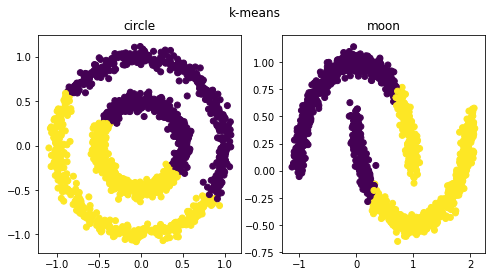

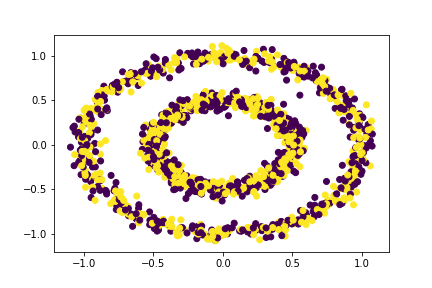

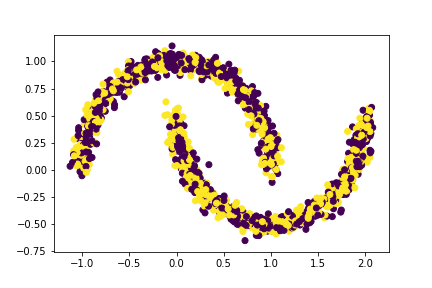

In [9]:
y_circle = kmeans(circle, return_step=True)
y_moon = kmeans(moon, return_step=True)
plot_graph(circle, moon, y_circle, y_moon, 'k-means', animated=True)

We can see that applying k-means on such data is a bad idea, since it cannot make use of the connectivity of data points, it only discover the compactness of them.

### 1.2 Kernel k-means
In kernel k-means, we do not find the mean and distance in original space, we find them in kernel space instead. The kernel function I use here is RBF kernel.

#### Define kernel function

In [10]:
def rbf_kernel(x1, x2, gamma = 5):
    """Custom kernel function which accept two list of samples and return a list of result."""
    euclidean = np.sqrt(np.sum((x1 - x2) ** 2, axis=1))
    rbf = np.exp(-gamma * euclidean ** 2)
    return rbf

#### Define function for precomputing data using kernel
This method form a matrix which the elements are kernel function of each pair of data points.

In [11]:
def precomputed(x1, x2, kernel_func):
    """Precomputed x1 with x2 using kernel function, return array of shape (n_x1, n_x2)."""
    result = np.zeros((x1.shape[0], x2.shape[0]))
    for j in range(result.shape[1]):
        x2_j = x2[j][None, :]
        result[:, j] = kernel_func(x1, x2_j)
    return result

#### Define main function for kernel k-means
Here is the step of kernel k-means:
1. Compute gram matrix using `precomputed()`
2. Initialize each data point's cluster
3. Compute distance of each data point $x_{j}$ to each centroid $C_{k}$ in kernel space, using the following equation  
   $k(x_{j}, x_{j}) - \frac{2}{|C_{k}|}\sum_{n}\alpha_{kn}k(x_{j}, x_{n}) + \frac{1}{|C_{k}|^{2}}\sum_{p}\sum_{q}\alpha_{kp}\alpha_{kq}k(x_{p}, x_{q})$
4. Use the index of smallest distance as its cluster
5. Repeat 3 and 4 until the cluster of each data point become stable

In [12]:
def kernel_kmeans(x, k=2, init_method=random_assign, return_step=False):
    """Perform kernel k-means clustering on x."""
    # Compute gram matrix
    gram_mat = precomputed(x, x, rbf_kernel)
    # Construct array of size (n_sample, k) to store distance
    distance = np.zeros((x.shape[0], k))
    # Randomly assign cluster to each x as initialization
    y = init_method(x, k)
    steps = y[:, None].copy()
    prev_y = y
    while True:
        # Compute all sample to each center's distance
        for cluster in range(k):
            mask = (y == cluster)
            first = gram_mat.diagonal()
            second = -2 * (mask * gram_mat).sum(axis=1) / mask.sum()
            third = (mask * (mask * gram_mat).sum(axis=1)).sum() / (mask.sum() ** 2)
            distance[:, cluster] = first + second + third
        # Pick the cluster with smallest distance
        y = np.argmin(distance, axis=1)
        steps = np.hstack((steps, y[:, None]))
        # Stop if y didn't change anymore
        if (prev_y == y).all():
            break
        prev_y = y
    return y if not return_step else steps

#### Perform kernel k-means on circle and moon

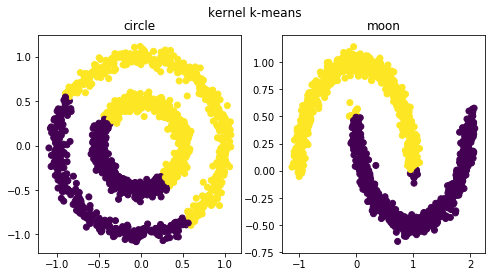

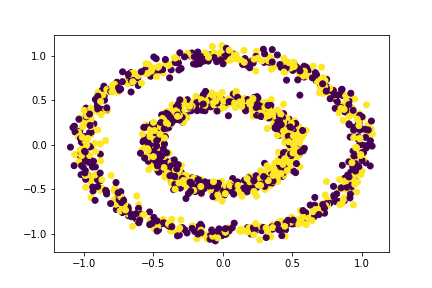

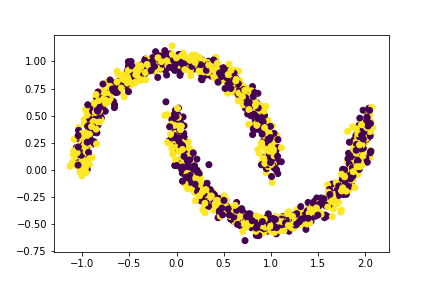

In [13]:
y_circle = kernel_kmeans(circle, return_step=True)
y_moon = kernel_kmeans(moon, return_step=True)
plot_graph(circle, moon, y_circle, y_moon, 'kernel k-means', animated=True)

Although kernel k-means make a different clustering result compare with classical k-means, it cannot perfectly divide these two dataset. The main reason is that it highly depend on the initialization, a good initial point can make a good prediction. The initialization approach I use here is randomly assign cluster, which will result in very similr centroid. Consequently, kernel k-means have the ability to solve these problems, but it needs a good initial point.

### 1.3 Spectral clustering
We can treat spectral clustering as a variation of kernel k-means, because it transform data into an eigen space and then perform k-means on those data.  
Reference:
- https://towardsdatascience.com/spectral-clustering-82d3cff3d3b7

#### Define main function for spectral clustering
The steps of spectral clustering are as following:
1. Compute similarity graph using $w_{i,j} = e^{\frac{\lVert x_{i}-x_{j}\rVert ^{2}}{2\sigma^{2}}}$, and represent it as a matrix $A$
2. Get degree matrix with $d_{i} = \sum_{j=0}^{N} w_{i,j}$
3. Calculate graph laplacian, $L=D-A$
4. Get the eigen value and vector from $L$, and sort them according to eigen value
5. Depending on how many `k`, feed the first `k` column of eigen vector to k-means
6. The final result is the k-means result

In [14]:
def spectral_clustering(x, k=2, gamma=50, init_method=random_assign, return_step=False, return_eigen=False):
    distance_mat = np.sqrt(np.sum((x[:, None, :] - x) ** 2, axis=2))
    adjacency_mat = np.exp(-gamma * (distance_mat ** 2))
    degree_mat = np.diag(adjacency_mat.sum(axis=1))
    graph_laplacian = degree_mat - adjacency_mat
    eigen_val, eigen_vec = np.linalg.eig(graph_laplacian)
    eigen_vec = eigen_vec[:,np.argsort(eigen_val)]
    eigen_val = eigen_val[np.argsort(eigen_val)]
    y = kmeans(eigen_vec[:, 0:k], k=k, init_method=init_method, return_step=return_step)
    return y if not return_eigen else (y, (eigen_val, eigen_vec))

#### Perform spectral clustering on circle and moon

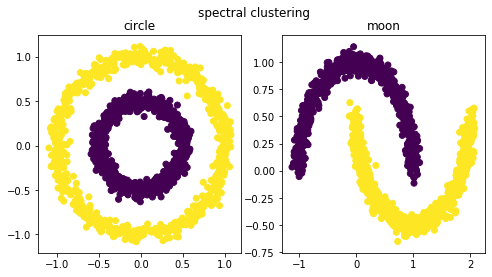

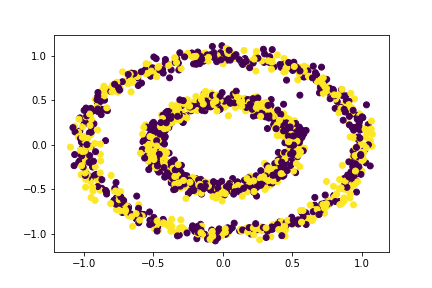

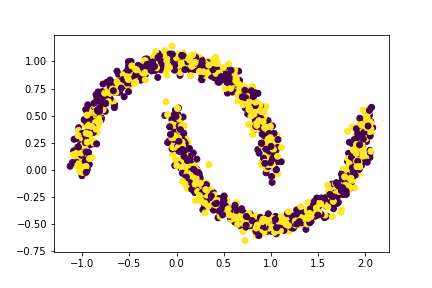

In [15]:
y_circle = spectral_clustering(circle, return_step=True)
y_moon = spectral_clustering(moon, return_step=True)
plot_graph(circle, moon, y_circle, y_moon, 'spectral clustering', animated=True)

This method can make a perfect clustering with only one step, the eigen space representation is much better for clustering than kernel k-means.

### 1.4 DBSCAN
Reference:
- https://en.wikipedia.org/wiki/DBSCAN

#### Define main function for DBSCAN
DBSCAN does not require much calculation, without transforming to any space, just do it in original space. It utilitze the connectivity property of each data point

In [16]:
def dbscan(x, epsilon=0.15, min_points=3, return_step=False, step_resolution=50):
    """Perform DBSCAN clustering on x."""
    def find_neighbors(distance, radius=epsilon):
        """Return index of distance which is smaller than radius."""
        return np.argwhere(distance < radius).flatten()
    cluster = 0
    # Initialize label of each data point(0:unlabelled, -1:noise, >0:cluster)
    y = np.zeros(x.shape[0], dtype=int)
    steps = y[:, None].copy()
    # Compute distance matrix using broadcasting in numpy
    distance_mat = np.sqrt(np.sum((x[:, None, :] - x) ** 2, axis=2))
    # Iterate each data point
    for i in range(x.shape[0]):
        # Skip labelled data point
        if y[i] != 0:
            continue
        # Find index of neighbor which has distance smaller than epsilon from current point
        neighbors_idx = find_neighbors(distance_mat[i])
        # Mark as noise due to not enough neighbors
        if neighbors_idx.shape[0] < min_points:
            y[i] = -1
            continue
        # Assign new cluster
        cluster += 1
        y[i] = cluster
        # Visit all neighbors and corresponding neighbors
        neighbors_idx = neighbors_idx[neighbors_idx != i]
        while neighbors_idx.shape[0] > 0:
            idx = neighbors_idx[0]
            # Process unlabelled or noise neighbor
            if y[idx] <= 0:
                # Find unlabelled neighbor's neighbors
                if y[idx] == 0:
                    new_neighbors_idx = find_neighbors(distance_mat[idx])
                    if new_neighbors_idx.shape[0] >= min_points:
                        neighbors_idx = np.append(neighbors_idx, new_neighbors_idx)
                # Assign current cluster
                y[idx] = cluster
                steps = np.hstack((steps, y[:, None]))
            neighbors_idx = neighbors_idx[1:]
    # Map label back to 0 start
    steps[steps == steps.max()] = 0
    return y - 1 if not return_step else steps[:, ::step_resolution]

#### Perform DBSCAN on circle and moon

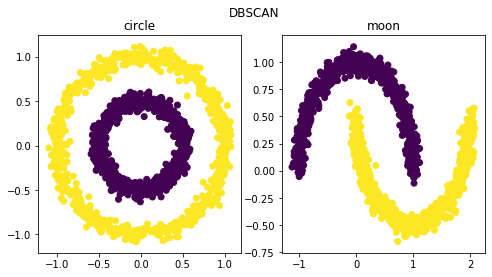

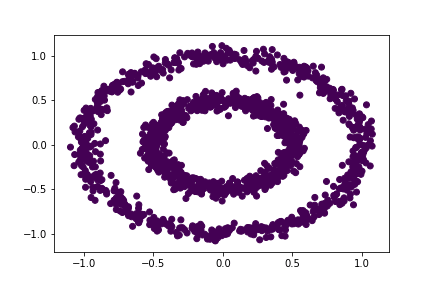

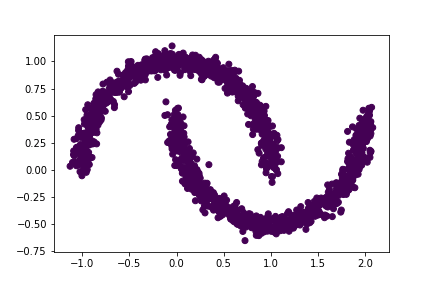

In [17]:
y_circle = dbscan(circle, return_step=True)
y_moon = dbscan(moon, return_step=True)
plot_graph(circle, moon, y_circle, y_moon, 'DBSCAN', animated=True)

DBSCAN is another method that can perfectly divide those data into clusters, as it use the neighbors' information in clustering.

### 1.5 Summary
For the four clustering algorithm, I think spectral clustering is the most suitable method for clustering in these two dataset because it give a perfect result without much parameter tuning. DBSCAN is also good, but it require us to dig deep into data and find appropriate parameters to get good result.

## 2 Different k

### 2.1 k-means

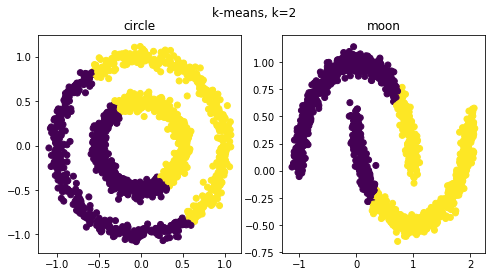

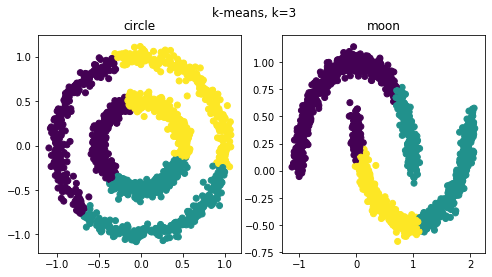

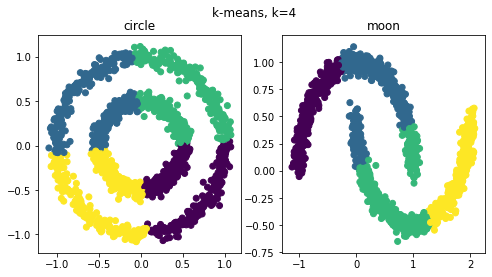

In [18]:
k_to_try = [2, 3, 4]
for k in k_to_try:
    y_circle = kmeans(circle, k=k)
    y_moon = kmeans(moon, k=k)
    plot_graph(circle, moon, y_circle, y_moon, f'k-means, k={k}')

Again, bad result with each `k`

### 2.2 Kernel k-means

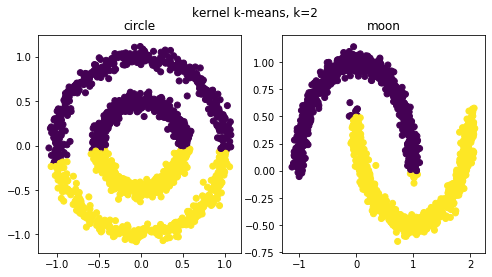

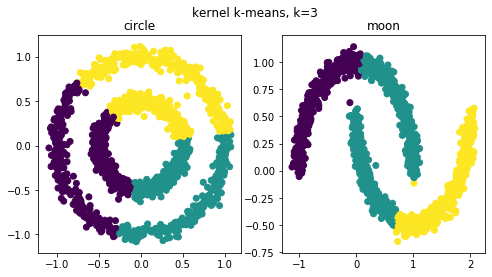

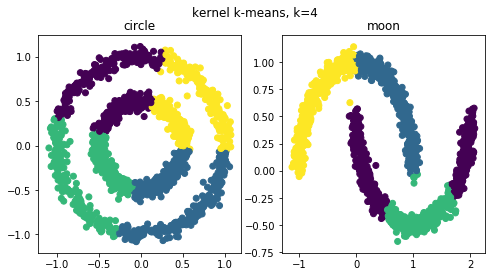

In [19]:
for k in k_to_try:
    y_circle = kernel_kmeans(circle, k=k)
    y_moon = kernel_kmeans(moon, k=k)
    plot_graph(circle, moon, y_circle, y_moon, f'kernel k-means, k={k}')

Also, kernel k-means do not partition the data very well.

### 2.3 Spectral clustering

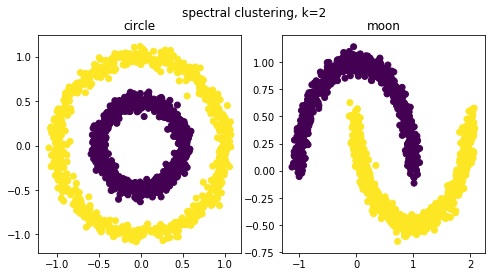

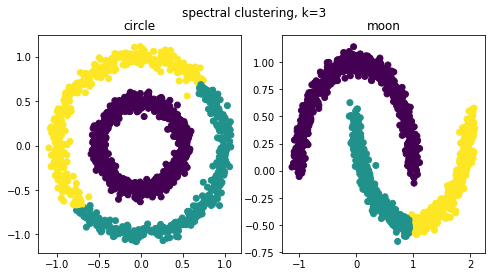

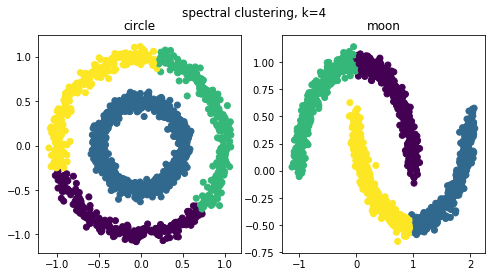

In [20]:
for k in k_to_try:
    y_circle = spectral_clustering(circle, k=k)
    y_moon = spectral_clustering(moon, k=k)
    plot_graph(circle, moon, y_circle, y_moon, f'spectral clustering, k={k}')

Spectral clustering handle each `k` in a better condition, as we can see the separation of `moon` on `k=4` is very uniform, although it may not be the best choice of `k`.

### 2.4 DBSCAN
DBSCAN don't need the parameter `k`, it will automatically find appropriate number of groups to cluter. However, it has parameter $\epsilon$ and `min_pts` which need to be set carefully to obtain the best result. Here, we try some different parameters.

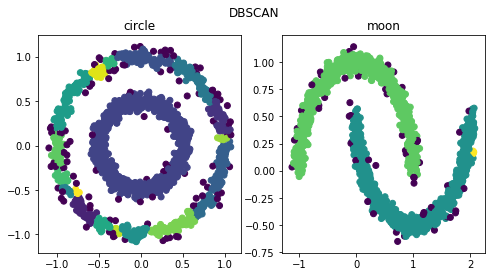

In [21]:
y_circle = dbscan(circle, epsilon=0.05, min_points=5)
y_moon = dbscan(moon, epsilon=0.05, min_points=5)
plot_graph(circle, moon, y_circle, y_moon, 'DBSCAN')

## 3 Different initialization method
Here I use k-means++ as alternative initialization method
The initialization procedure of k-means++ is as following:
1. Randomly pick one sample as first centroid
2. Compute distance of each data point from nearest centroid
3. Choose a data point as next centroid according to distance computed in step 2, longer distance have high probability to be picked
4. Repect 2 and 3 until `k` centroid have been found

#### Define the k-means++ initialization method

In [22]:
def kmpp_assign(x, n_class):
    """Initialization method which use k-means++ for assigning class."""
    # Find n means from x
    means = None
    for c in range(n_class):
        if means is None:
            mean = x[np.random.choice(x.shape[0])]
            means = mean[None, :]
            continue
        distance_to_means = np.sqrt(np.sum(((x[:, None, :] - means) ** 2), axis=2))
        closest_distance_to_means = distance_to_means.min(axis=1)
        probability = closest_distance_to_means / closest_distance_to_means.sum()
        mean = x[np.random.choice(x.shape[0], p=probability)]
        means = np.vstack((means, mean))
    y = assign_cluster(x, means)
    return y

### 3.1 k-means

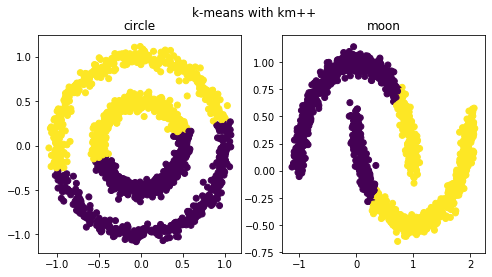

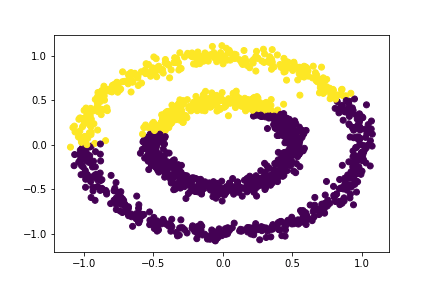

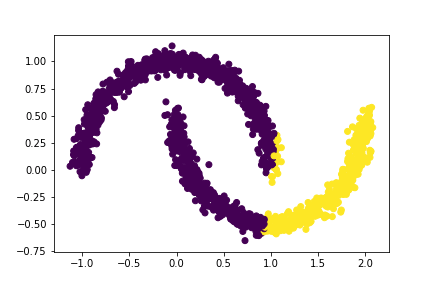

In [23]:
y_circle = kmeans(circle, init_method=kmpp_assign, return_step=True)
y_moon = kmeans(moon, init_method=kmpp_assign, return_step=True)
plot_graph(circle, moon, y_circle, y_moon, 'k-means with km++', animated=True)

### 3.2 kernel k-means

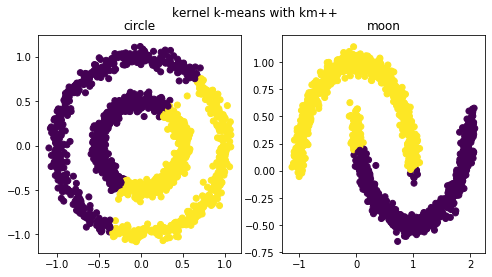

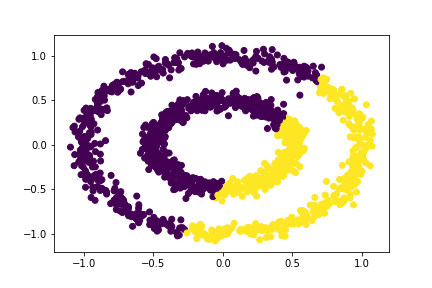

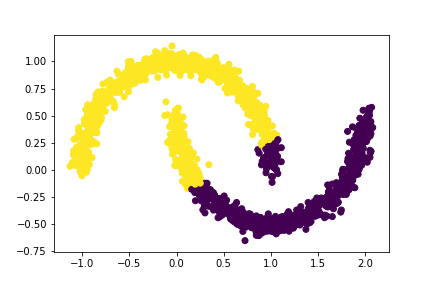

In [24]:
y_circle = kernel_kmeans(circle, init_method=kmpp_assign, return_step=True)
y_moon = kernel_kmeans(moon, init_method=kmpp_assign, return_step=True)
plot_graph(circle, moon, y_circle, y_moon, 'kernel k-means with km++', animated=True)

### 3.3 Spectral k-means

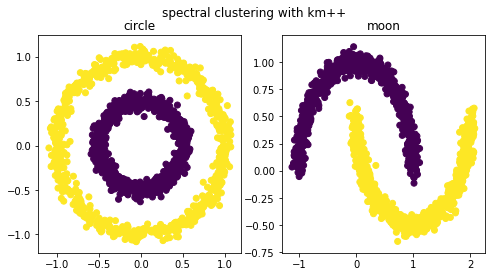

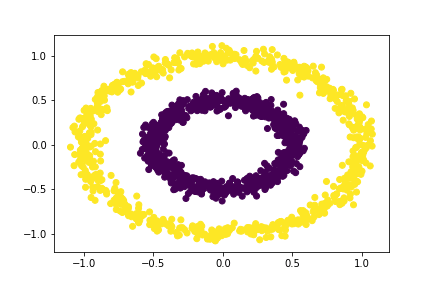

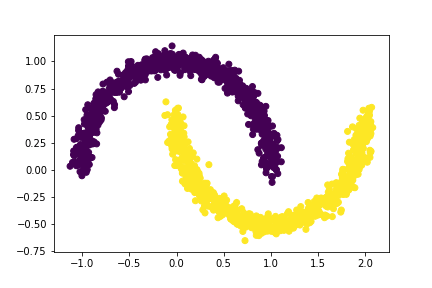

In [25]:
y_circle = spectral_clustering(circle, init_method=kmpp_assign, return_step=True)
y_moon = spectral_clustering(moon, init_method=kmpp_assign, return_step=True)
plot_graph(circle, moon, y_circle, y_moon, 'spectral clustering with km++', animated=True)

Comparing the animation of part 3 to part 1, we can see that at the begining, the label of each data point won't be very random. They look like they have been simply partition first. As a result, it can prevent the problem such as infinity loop when using `random_assign()` approach. In spectral cluster, the reason that there is no animation is because the data points form two group at the initial step due to eigen space. I will show this in the next section.

## 4 Eigen space visualization in spectral clustering

#### Get eigen value and vector when performing clustering

In [26]:
y_circle, circle_eigen = spectral_clustering(circle, return_eigen=True)
y_moon, moon_eigen = spectral_clustering(moon, return_eigen=True)

#### Plot first ten eigen value and first two column of eigen vector

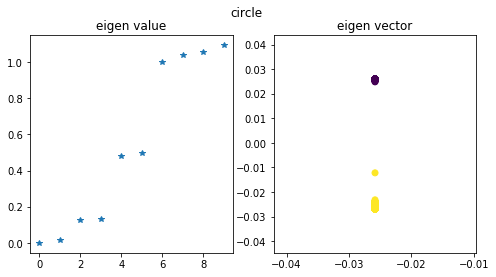

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('circle')
ax[0].plot(circle_eigen[0][:10], '*')
ax[0].set_title('eigen value')
ax[1].scatter(circle_eigen[1][:, 0], circle_eigen[1][:, 1], c=y_circle)
ax[1].set_title('eigen vector')
plt.show()

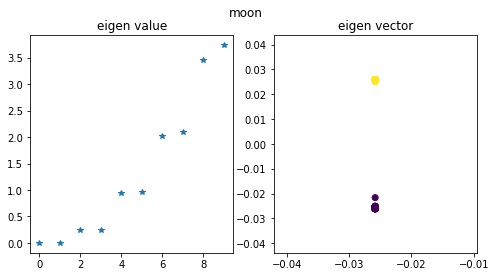

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('moon')
ax[0].plot(moon_eigen[0][:10], '*')
ax[0].set_title('eigen value')
ax[1].scatter(moon_eigen[1][:, 0], moon_eigen[1][:, 1], c=y_moon)
ax[1].set_title('eigen vector')
plt.show()

The graph of left hand side show the first ten eigen value, two points at y=0 means there is two connected components in the graph, so we can choose `k` depending on this information. The graph on right hand side show the first two columns of eigen vectors, we can easily observe that there a two group of data points. After putting them into k-means, we get the clustering result.